In [252]:
# Imports
import os
import matplotlib.pyplot as plt
from torch import nn
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, random_split


In [253]:
# Define nn model
class BasicMNISTClassifer(nn.Module):
    def __init__(self):
        super(BasicMNISTClassifer, self).__init__()

        # Layer 1
        self.layer1 = nn.Linear(28*28, 128)
        self.activation1 = nn.ReLU()

        # Layer 2
        self.layer2 = nn.Linear(128, 256)
        self.activation2 = nn.ReLU()

        # Layer 3
        self.layer3 = nn.Linear(256, 10)
        
        # Output layer
        self.output = nn.LogSoftmax(dim=1)
        self.out = []
    
    def forward(self, x):
        batch_size, channels, width, height = x.shape
        # flatten all dims except batch
        x = x.view(batch_size, -1)
        
        # Move input through layers
        for module in self.modules():
            # First module is a reference to the model
            if module == self:
                continue
            x = module(x)
        return x

In [ ]:
# Explore strucure of model
model = BasicMNISTClassifer()
model.state_dict().keys()

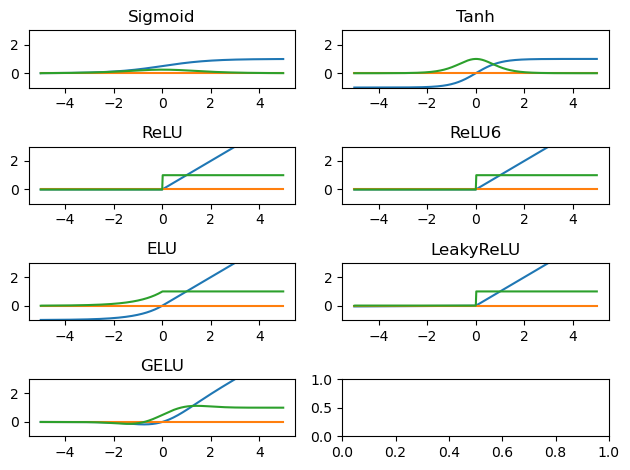

In [258]:
# Explore activations
activations = [
    'Sigmoid',
    'Tanh',
    'ReLU',
    'ReLU6',
    'ELU',
    'LeakyReLU',
    'GELU'
]

# Create subplots
cols = 2
rows = len(activations)//cols + 1
fig, axes = plt.subplots(rows, cols)


# Iterate over activation functions
x_step = 0.02
# x = torch.linspace(-5, 5, 100)
x = torch.arange(-5, 5, x_step)
for num, activation in enumerate(activations):
    fnc = getattr(nn, activation)()
    y = fnc(x)
    ax = axes[divmod(num, cols)]
    ax.plot(x, y)
    ax.plot(x, x*0)
    ax.set_title(activation)
    ax.set_ylim(-1.0, 3.0)
    # numerical grad, assume left of grad tends to zero
    dy = torch.hstack((torch.zeros((1)), torch.diff(y)/x_step))
    ax.plot(x, dy)
    fig.tight_layout()
# fig.subplots_adjust(hspace=0.3, vspace=0.3)

In [259]:
# Load, transform, and split data
# Load data
batch_size = 16
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Training data
train_data = MNIST(os.getcwd(), train=True, download=True, transform=transform)
train_data, val_data = random_split(train_data, [0.9, 0.1])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Testing data
test_data = MNIST(os.getcwd(), train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

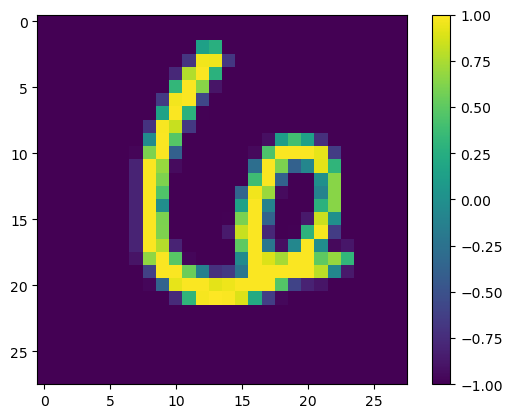

In [261]:
# Explore images returned by dataloader iterator
# Each item returns list of two objects
# 1st object is tensor of batched images
# 2nd object is tensor of target labels
# batch tensor has shape of (batch_size, channels, width, height)
for itm in val_loader:
    plt.imshow((itm[0][0,0,:,:]))
    plt.colorbar()
    break

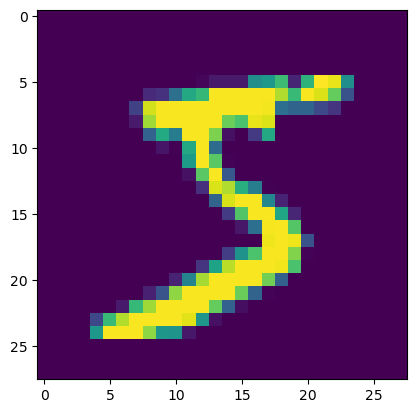

In [262]:
# Explore some example images from the dataset
data_index = torch.randint(0, 60000)
img_sample = train_data.dataset.data[data_index]
plt.imshow(img_sample)

In [391]:
# Training and validation
loss_fnc = torch.nn.functional.nll_loss
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer = torch.optim.SGD(model.parameters, lr=1e-4)

num_epochs = 20
for epoch in range(num_epochs):

    # Training
    train_loss = []
    for batch in train_loader:
        # Forward batch
        x, y = batch
        logits = model(x)
        loss = loss_fnc(logits, y)
        train_loss.append(loss)

        # Backprop and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation
    with torch.no_grad():
        val_loss = []
        for batch in val_loader:
            # Forward batch
            x, y = batch
            logits = model(x)
            loss = loss_fnc(logits, y)
            val_loss.append(loss)
            # val_loss = torch.mean(torch.tensor(val_loss))
    # Update progress
    print(f'{epoch=}: {train_loss[-1]=}, {val_loss[-1]=}')



epoch=0: train_loss[-1]=tensor(0.0002, grad_fn=<NllLossBackward0>), val_loss[-1]=tensor(0.9719)
epoch=1: train_loss[-1]=tensor(1.1317e-05, grad_fn=<NllLossBackward0>), val_loss[-1]=tensor(1.0962)
epoch=2: train_loss[-1]=tensor(9.9092e-07, grad_fn=<NllLossBackward0>), val_loss[-1]=tensor(2.4587e-07)
epoch=3: train_loss[-1]=tensor(0.0008, grad_fn=<NllLossBackward0>), val_loss[-1]=tensor(2.0354e-05)
epoch=4: train_loss[-1]=tensor(0.0108, grad_fn=<NllLossBackward0>), val_loss[-1]=tensor(0.0016)
epoch=5: train_loss[-1]=tensor(7.3535e-06, grad_fn=<NllLossBackward0>), val_loss[-1]=tensor(0.0002)
epoch=6: train_loss[-1]=tensor(1.9371e-06, grad_fn=<NllLossBackward0>), val_loss[-1]=tensor(0.0553)
epoch=7: train_loss[-1]=tensor(9.0897e-07, grad_fn=<NllLossBackward0>), val_loss[-1]=tensor(2.8130e-05)
epoch=8: train_loss[-1]=tensor(0., grad_fn=<NllLossBackward0>), val_loss[-1]=tensor(0.)
epoch=9: train_loss[-1]=tensor(0.0004, grad_fn=<NllLossBackward0>), val_loss[-1]=tensor(0.0036)
epoch=10: train_

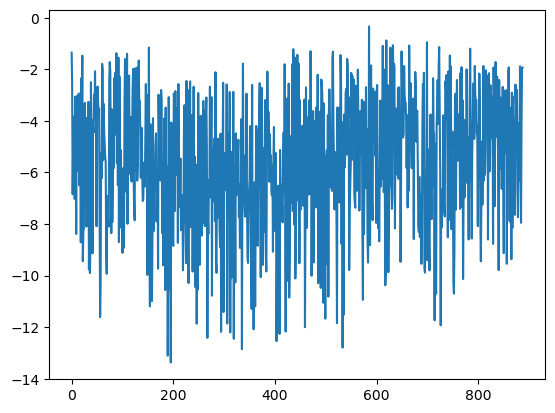

In [312]:
# Evaluate training and validation loss curves
plt.plot(range(len(train_loss)), [torch.log(loss).detach() for loss in train_loss])
plt.plot(range(len(val_loss)), [torch.log(loss).detach() for loss in val_loss])

In [363]:
samples = [itm for itm in sample]
len(samples)

32

In [379]:
sample.shape

torch.Size([1, 1, 1, 28, 28])

In [387]:
samples, targets, predictions = [], [], []
for batch_samples, batch_targets in test_loader:
    samples += [sample.squeeze() for sample in batch_samples]
    targets += batch_targets.tolist()
    
    for sample, target in zip(batch_samples, batch_targets):
        sample = sample.unsqueeze(dim=0)
        output = model(sample)
        output = torch.exp(output)
        prediction = torch.argmax(output)
        # target = target.item()
        predictions.append(prediction)

In [390]:
sum([target == prediction for target, prediction in zip(targets, predictions)])/len(targets)*100

tensor(97.1100)

tensor([[7.9603e-14, 2.8346e-14, 5.0371e-14, 1.4132e-06, 4.8016e-15, 5.6404e-09,
         2.7216e-21, 1.0000e+00, 1.0565e-14, 1.9809e-06]],
       grad_fn=<ExpBackward0>)
7


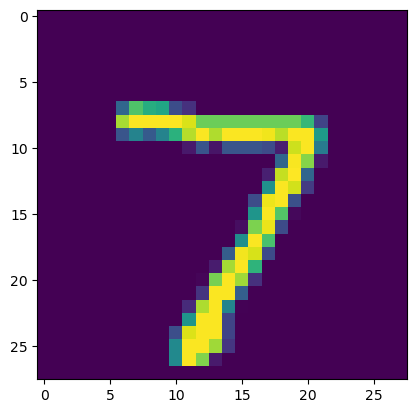

In [336]:
next_sample = next(test_loader.__iter__())
img_bitmap = next_sample[0][0].squeeze()
plt.imshow(img_bitmap)
img_sample = next_sample[0][0].unsqueeze(dim=0)

output = model(img_sample)
print(torch.exp(output))
print(torch.argmax(output).item())